# KVLCC2 Model tests vs. Ikeda and SI

# Purpose
Comparison between damping coefficients (with and without speed) from model tests and predictions with Ikeda and Simplified Ikeda (SI).

# Methodology
Quickly describe assumptions and processing steps.

# WIP - improvements
(WORK IN PROGRESS)
Use this section only if the notebook is not final.

Notable TODOs:
* todo 1
* todo 2
* todo 3

## Results
Describe and comment the most important results.

# Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [18]:
import pyscores2
import pyscores2.runScores2
import pyscores2.xml_hydrostatics
from pyscores2.output import OutputFile
from rolldecayestimators.ikeda import Ikeda, IkedaR

from rolldecayestimators.simplified_ikeda_class import SimplifiedIkeda, SimplifiedIkedaABS
from rolldecayestimators.simplified_ikeda import limits_kawahara
from pyscores2.runScores2 import Calculation
from pyscores2.indata import Indata
import joblib
from scipy.optimize import least_squares

In [3]:
db = database.get_db()

In [4]:
sql = """
SELECT * from run
INNER JOIN loading_conditions
ON (run.loading_condition_id = loading_conditions.id)
INNER JOIN models
ON (run.model_number = models.model_number)
INNER JOIN ships
ON (run.ship_name = ships.name)
WHERE run.model_number='M5057-01-A' and run.test_type='roll decay' and run.project_number=40178362;
"""
df_rolldecays = pd.read_sql(sql=sql, con=db.engine)
df_rolldecays=df_rolldecays.loc[:,~df_rolldecays.columns.duplicated()]
df_rolldecays.set_index('id', inplace=True)

df_rolldecays['ship_speed'].fillna(0, inplace=True)


In [5]:
df_rolldecays.head()

,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,Körfallstyp,name,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21337,40178362,1,94,1,M5057-01-A,M5057-01-A,166,94.0,0.0,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,None,None,None,20.8,11.2672,18.6,5.73,None,20.8,20.8,None,23.2,80.0,None,None,312653.0,0.99538,None,68.0,320.0,58.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
21338,40178362,1,95,1,M5057-01-A,M5057-01-A,166,95.0,0.0,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,None,None,None,20.8,11.2672,18.6,5.73,None,20.8,20.8,None,23.2,80.0,None,None,312653.0,0.99538,None,68.0,320.0,58.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
21339,40178362,1,96,1,M5057-01-A,M5057-01-A,166,96.0,0.0,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-11-28,roll decay,MDL,None,None,None,20.8,11.2672,18.6,5.73,None,20.8,20.8,None,23.2,80.0,None,None,312653.0,0.99538,None,68.0,320.0,58.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
21340,40178362,1,97,1,M5057-01-A,M5057-01-A,166,97.0,15.5,"Roll decay, 15.5 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-04,roll decay,MDL,None,None,None,20.8,11.2672,18.6,5.73,None,20.8,20.8,None,23.2,80.0,None,None,312653.0,0.99538,None,68.0,320.0,58.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [6]:
def calculate_ikeda(ikeda):

    output = pd.DataFrame()
    output['B_44_hat']   = ikeda.calculate_B44()
    output['B_W0_hat']   = float(ikeda.calculate_B_W0())
    output['B_W_hat']    = float(ikeda.calculate_B_W())
    output['B_F_hat']    = ikeda.calculate_B_F()
    output['B_E_hat']    = ikeda.calculate_B_E()
    output['B_BK_hat']   = ikeda.calculate_B_BK()
    output['B_L_hat']    = float(ikeda.calculate_B_L())
    output['Bw_div_Bw0'] = float(ikeda.calculate_Bw_div_Bw0())
    return output

In [7]:
#df_rolldecays=df_rolldecays.loc[[21337,21338,21340,]].copy()
df_rolldecays=df_rolldecays.loc[[21338,21340,]].copy()

In [8]:
resources={
    21338 : {
        'scores_indata_path':'../models/KVLCC2_speed.IN',
        'scores_outdata_path':'../data/interim/KVLCC2_speed.out',
        'roll_decay_model':'../models/KVLCC2_0_speed.pkl',
    },
    21340 : {
        'scores_indata_path':'../models/KVLCC2_speed.IN',
        'scores_outdata_path':'../data/interim/KVLCC2_speed.out',
        'roll_decay_model':'../models/KVLCC2_speed.pkl',
    }
}

In [10]:
g=9.81
rho=1000

phi_as = np.deg2rad(np.linspace(0,10,30))
results = pd.DataFrame()

for id, row in df_rolldecays.iterrows():
    run = db.session.query(Run).get(int(row.name))
    run = database.load_run(run, save_as_example=False, prefer_hdf5=True)
    scale_factor = run.model.scale_factor
    
    resource = resources[id]
    
    ## Load ScoresII results
    indata = Indata()
    indata.open(indataPath='../models/KVLCC2_speed.IN')
    output_file = OutputFile(filePath='../data/interim/KVLCC2_speed.out')
    
    ## Compare with model test
    model = joblib.load(resource['roll_decay_model'])
    estimator = model['estimator']
    
    ## Non. Lin. linear equivalent damping
    GM = run.loading_condition.gm/scale_factor
    volume = run.loading_condition.Volume/(scale_factor**3)
    GM = run.loading_condition.gm/scale_factor
    beam = run.ship.beam/scale_factor

    meta_data = {
        'Volume':volume,
        'GM':GM,
    }
    parameters = estimator.result_for_database(meta_data = meta_data)
    B_e = lambdas.B_e_lambda_cubic(B_1=parameters['B_1'], B_2=parameters['B_2'], B_3=parameters['B_3'], 
                                   omega0=parameters['omega0'], phi_a=phi_as)
    B_e_hat = lambdas.B_hat_lambda(B=B_e, Disp=volume, beam=beam, g=g, rho=rho)

    ## Run Ikeda
    w = parameters['omega0']
    scale_factor=run.model.scale_factor
    V = row.ship_speed*1.852/3.6/np.sqrt(scale_factor)
    
    if not run.ship.BKL:
        BKL=0
    else:
        BKL=run.ship.BKL/scale_factor
    
    if not run.ship.BKB:
        BKB = 0
    else:
        BKB=run.ship.BKB/scale_factor
    
    fi_as = np.deg2rad(10)
    
    BKL_ = BKL*np.ones(len(phi_as))
    BKB_ = BKB*np.ones(len(phi_as))
    
    ikeda = Ikeda.load_scoresII(V=V, w=w, fi_a=phi_as, indata=indata, output_file=output_file, 
                                scale_factor=scale_factor, BKL=BKL_, BKB=BKB_)
    
    R = 0.15*run.ship.beam/scale_factor  # Just guessing...
    ikeda.R = R
    
    df_ikeda = calculate_ikeda(ikeda=ikeda)
    df_ikeda['phi_as']=phi_as
    df_ikeda.set_index('phi_as',inplace=True)
    df_ikeda['phi_as_deg']=np.rad2deg(phi_as)
    df_ikeda['B_e_hat_model_test']=B_e_hat
    df_ikeda['B_e_hat_model_test']=df_ikeda['B_e_hat_model_test'].astype('float')
    df_ikeda['id']=id
    results=results.append(df_ikeda)
        

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:245: RuntimeWarning: divide by zero encountered in true_divide
  Rn = 0.512 * (r_f/fi_a) ** 2 * w / visc;
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:183: RuntimeWarning: invalid value encountered in true_divide
  CD = 22.5 * bBK / (pi * l * fi_a * f) + 2.4;
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:189: RuntimeWarning: divide by zero encountered in true_divide
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:189: RuntimeWarning: invalid val

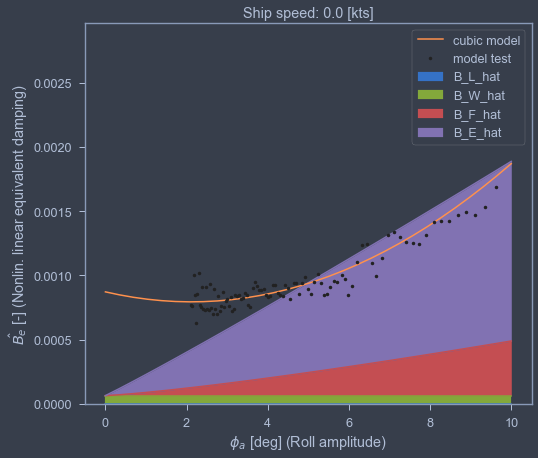

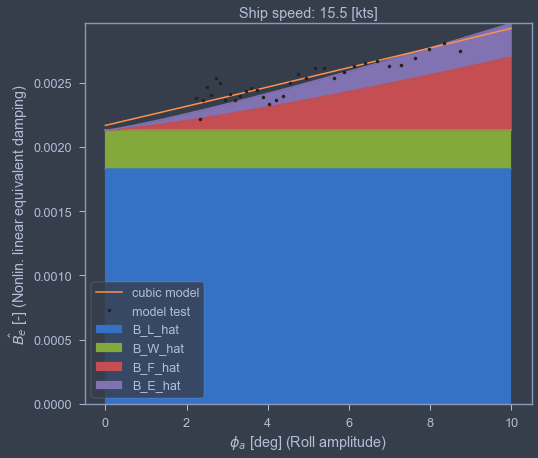

In [11]:
ymax = np.max([df_ikeda['B_44_hat'].max(),df_ikeda['B_e_hat_model_test'].max()])
for id,df_ikeda in results.groupby(by='id'):
    fig,ax=plt.subplots()
    interesting_ = ['B_L_hat','B_W_hat','B_F_hat','B_E_hat',]
    df_ikeda.plot.area(x='phi_as_deg', y=interesting_, ax=ax)
    
    df_ikeda.plot(x='phi_as_deg',y='B_e_hat_model_test', label='cubic model', ax=ax)
    
    resource = resources[id]
    model = joblib.load(resource['roll_decay_model'])
    estimator = model['estimator']
    X_amplitudes=estimator.X_amplitudes.copy()
    X_amplitudes['phi_a_deg'] = np.rad2deg(X_amplitudes['phi_a'])
    result_for_database = estimator.result_for_database(meta_data=meta_data)
    omega0=result_for_database['omega0']
    A_44=result_for_database['A_44']
    X_amplitudes['B']=X_amplitudes['B_n']*2*omega0*A_44/2
    
    X_amplitudes['B_hat'] = lambdas.B_hat_lambda(B=X_amplitudes['B'], Disp=volume, beam=beam, g=g, rho=rho)
    X_amplitudes.plot(x='phi_a_deg', y='B_hat', style='k.', label='model test', ax=ax)
    
    ax.legend()
    ax.set_xlabel('$\phi_a$ [deg] (Roll amplitude)')
    ax.set_ylabel('$\hat{B_e}$ [-] (Nonlin. linear equivalent damping)');
    
    s = df_rolldecays.loc[id]
    title='Ship speed: %0.1f [kts]' % s.ship_speed
    ax.set_title(title)    
    ax.set_ylim(0,ymax)

## Time 

In [45]:
def residual(x,df, omega0):
    """
    Residual function for least square fit
    """
    
    B_1 = x[0]
    B_2 = x[1]
    B_3 = x[2]
    
    phi_a = df.index
    B_e_pred = lambdas.B_e_lambda_cubic(B_1=B_1, B_2=B_2, B_3=B_3, omega0=omega0, phi_a=phi_a)
    B_e_true = df['B_44']    
    error = B_e_true-B_e_pred
    
    return error
    

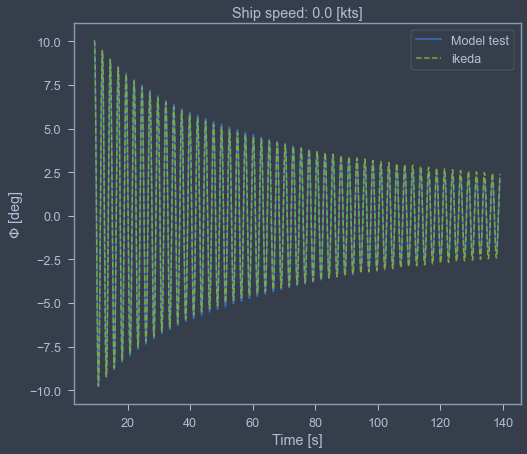

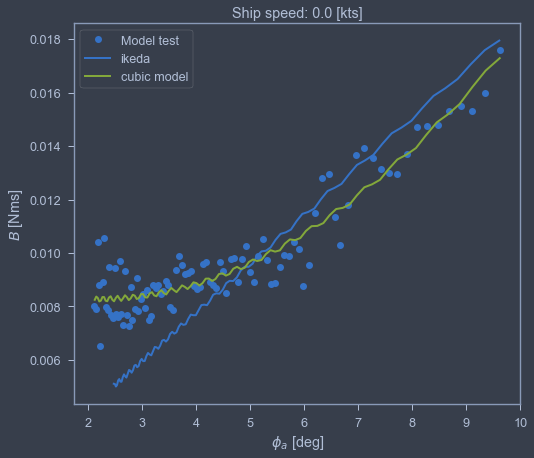

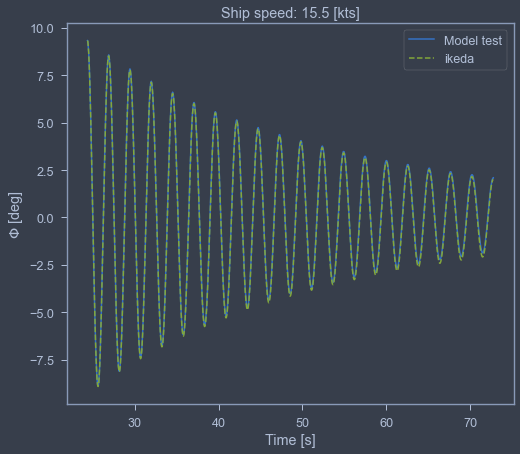

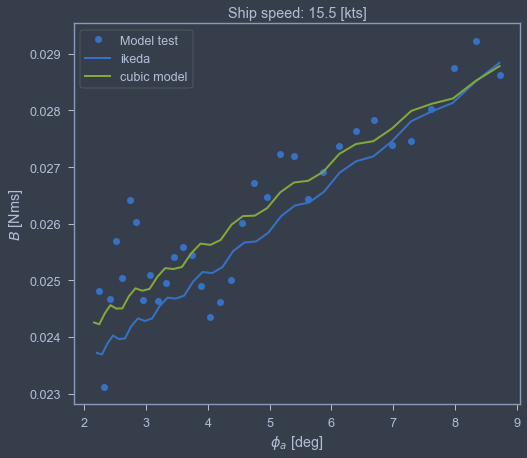

In [47]:
for id,df_ikeda in results.groupby(by='id'):
    
    ## Convert to dimensional damping [Nm/s]
    df_ikeda['B_44'] = lambdas.B_from_hat_lambda(B_44_hat=df_ikeda['B_44_hat'], Disp=volume, beam=beam, g=g, rho=rho)
    
    ## Load the cubic model
    resource = resources[id]
    model = joblib.load(resource['roll_decay_model'])
    estimator = model['estimator']
    result_for_database = estimator.result_for_database(meta_data=meta_data)
    omega0=result_for_database['omega0']
    A_44=result_for_database['A_44']
    
    ## Use least square fit of B_44 as a function of phi_a to determine B_1, B_2 and B_3:
    x0 = [result_for_database['B_1'],
      result_for_database['B_2'],
      result_for_database['B_3'],
     ]
    kwargs = {
    'df':df_ikeda,
    'omega0':omega0,
    }

    result = least_squares(fun=residual, x0=x0, kwargs=kwargs, method='lm')
    assert result.success
    
    ## Feed the results into a cubic model:
    parameters = {
    'B_1A':result.x[0]/A_44,
    'B_2A':result.x[1]/A_44,
    'B_3A':result.x[2]/A_44,
    'C_1A':estimator.parameters['C_1A'],
    'C_3A':estimator.parameters['C_3A'],
    'C_5A':estimator.parameters['C_5A'],
    }

    model_ikeda = EstimatorCubic.load(**parameters, X=estimator.X)
    
    ## Plotting:
    fig,ax=plt.subplots()
    model_ikeda.plot_fit(label='ikeda', ax=ax)
    s = df_rolldecays.loc[id]
    title='Ship speed: %0.1f [kts]' % s.ship_speed
    ax.set_title(title)    

    fig,ax=plt.subplots()
    model_ikeda.plot_damping(label='ikeda', ax=ax)
    model['estimator'].plot_damping(label='cubic model', include_model_test=False, ax=ax)
    ax.set_title(title) 
    
    